이미지 전처리 -> pre_processing()

 점자 좌표 탐색 -> find_location()


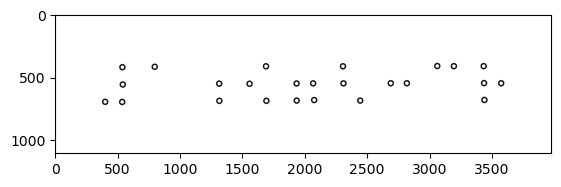


 점자 좌표 보정 -> modify_location()


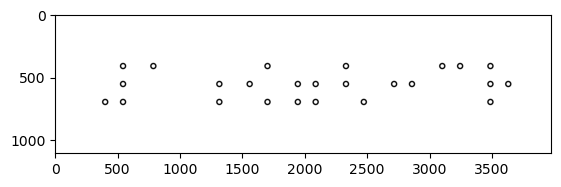


 점자 추출 -> find_braille()


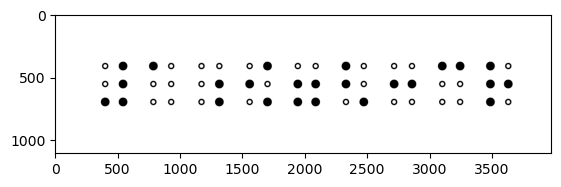

(0, 0, 1, 1, 1, 1)
(1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 1)
(0, 1, 1, 0, 1, 1)
(1, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 1, 0)
(1, 0, 0, 1, 0, 0)
(1, 1, 1, 0, 1, 0)


In [1]:
# 이미지 자르기 & 배경 생성 ( 색까지 ) & 배경에 자른 이미지 붙이기 적용된 코드
# 점자 판단이 잘 이루어지지 않는 부분 수정 ( changeStandard_x 메서드 수정 )

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


#     plt.imshow(img)
#     plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()

    return img, thresh_cv



"""
2번 
resize 조절해야함
  resize 우선 생략했을 때 결과 이상
  아마 이건 3번 문제일듯
blank 크기 조절할 수 있음
"""


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

################################ 1차로 추리기
            
    # blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        # center_list.append([num, cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        # cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        # num += 1

    # plt.imshow(blank, cmap = 'gray')
    # plt.show()

    # print(*center_list)
    # center_list = []

############################### 이미지 자르기

    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

#     print('자른 사진')
#     plt.imshow(new_img)
#     plt.show()

############################### 이미지 크게 만들기 1. 배경 만들고 붙이기

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록

    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 255, dtype='uint8')
    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 0, dtype='uint8')
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

#     print('자른 사진을 배경에 합치기')
#     plt.imshow(bg)
#     plt.show()


    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg

############################### 이미지 크게 만들기 2. resize ➜ 안쓰는게 나을듯

    # 자른 사진 resize
    # new_img = cv2.resize(new_img, (3337, 1091))   # 크기 정해서 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 140 / ((max_y - min_y) / 2), fy= 140 / ((max_y - min_y) / 2)) # 비율로 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 1.5, fy= 1.5) # 비율로 resize


    # print('자른 사진 resize')
    # plt.imshow(new_img)
    # plt.show()

############################### 새로운 이미지에서 처음부터 시작

    # 중심점 초기화
    center = np.empty((0, 2), int) 

    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # blank = np.full([thresh_cv.shape[0] + 200, thresh_cv.shape[1] + 200], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      # if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()
      
    return center, center_list, blank



# 2-1
# 회전 보정
def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    # print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        # plt.imshow(img)
        # plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        # print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


#         print('회전 후')
#         plt.imshow(thresh_cv, cmap='gray')
#         plt.show()

        return thresh_cv



"""
3번에서 사용하는 메서드들이 중요
여기서 사용하는 모든 수치에 따라 결과가 다르게 나옴
"""



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist


    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    x_list = find_x(dist, standard_x)
    

    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)


    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)


    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    # num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      # cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)
      # num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2: # 0.25 는 내가 임의로 정함 ( 같은 점이라고 판단할만한 범위 )
        line.append([i])
      else:
        line[-1].append(i)

  # avg = [int(np.average(i)) for i in line]
  avg = [i[0] for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] >= int(1.7 * dist)):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  i = len(all_x)   # 반복 횟수
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.7)

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
    # 0.25는 임의로 잡은 숫자
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    
  return all_x



"""
3-3 에서 잘못된 좌표로 수정되거나
수정이 안되는 문제로 인해 4번 결과가 이상함
"""

# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
    num = min(new)
    standard[i] = num + standard[i] if num + standard[i] in x_list else standard[i] - num

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])





"""
결과가 좋지 않아도 4번은 웬만하면 문제가 없다
3번에서 잘못된 처리를 해서 4번이 잘못된 결과를 출력
"""


# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])


    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))


    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\plz2.jpg')  